In [1]:
import sys
sys.path.append("/home/ricky/Documents/from_work/git/NMR_FF_tools/relaxation_times/")
sys.path.insert(1, '/home/ricky/Documents/from_work/git/charged_molecules_binding/simulations_list/')

sys.path.append("../")

import numpy as np
#import relaxation_times as rt
#import manage_files as mf
#*import plotting as pt
import matplotlib.pyplot as plt
import os
import re
import yaml
import gc
import math
import warnings

from scipy.optimize import minimize

import SRT_optimization as srt

import random
from datetime import date
today = date.today()

import fnmatch

gc.collect()

0

<H3>Load the saved data</H3>
comes from 01_main_figure, in there data in more fields can be calculated and saved for the purposes of this part

In [2]:
gammaH=267.513*10**6;
gammaN=-27.166*10**6;
magn_field_MHz=850 # for values in MHz
magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6
save_labels=["small_peptides",
       "peptides_SDSmicelles",
       "Calmodulin",
       "CDNF",
       "EN2",
       "musMANF",
       "TonB"]

# data is saved in the form [[effTimes],[R1],[R2],[hetNOE]]

systems={}
for system in save_labels:
    systems[system]=np.loadtxt("../01_main_figure/simulation_SRT_vs_effTime/"+system+"_"+str(magn_field_MHz)+".dat")
    

# data is saved in the form [[effTimes,effTime[-1:0]],[R1limits_min,R1limits_max[-1:0]]]
# resp [[effTimes,effTime[-1:0]],[R2limits_min,R1limits_max[-1:0]]] - the data

limits={}
limits["R1"]=np.loadtxt("../01_main_figure/extremes_of_Redfield/R1_limits_"+str(magn_field_MHz)+".dat")
limits["R2"]=np.loadtxt("../01_main_figure/extremes_of_Redfield/R2_limits_"+str(magn_field_MHz)+".dat")


# data is saved as [[effTimes],[R1]], [[effTimes],[R2]], [[effTimes],[hetNOE]] 

oneTime={}
oneTime["R1"]=np.loadtxt("../01_main_figure/1timescale_data/R1_1timescale_"+str(magn_field_MHz)+".dat")
oneTime["R2"]=np.loadtxt("../01_main_figure/1timescale_data/R2_1timescale_"+str(magn_field_MHz)+".dat")
oneTime["hetNOE"]=np.loadtxt("../01_main_figure/1timescale_data/hetNOE_1timescale_"+str(magn_field_MHz)+".dat")

Do the linar fit for all 3 different systems, try to maybe combine them and look at the r square for the linear fit vs that for 1-timescale approximaTION, VS MAYBE THE ORIGINAL LINEAR APPROXIMATION

so it would be the linear fit for the whole data - the correct slope - 0.37 or whathever it is <br>
the linear aproximation <br>
the 1-timescale approximation

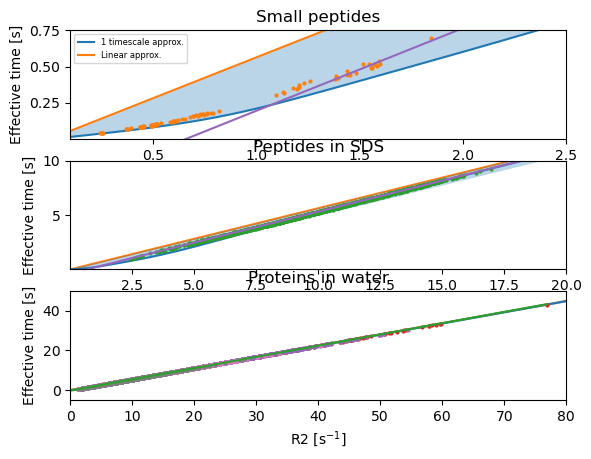

In [4]:
all_x=[]
all_y=[]

for sys in systems:
    all_x+=list(systems[sys][2])
    all_y+=list(systems[sys][0])

fit=np.polyfit(all_x,all_y,1)

# Ensin lasketaan ennustetut arvot suoralle
sorted_x=sorted(all_x)
y_predicted = fit[0] * np.array(all_x) + fit[1]
sorted_y = fit[0] * np.array(sorted_x) + fit[1]


fig, axs = plt.subplots(3, 1)

plt.rcParams["figure.figsize"] = [3, 6]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')


x2=np.logspace((-12),(-7),100)
axs[0].plot(oneTime["R2"][1],oneTime["R2"][0]*10**9,"-",label="1 timescale approx.")
axs[1].plot(oneTime["R2"][1],oneTime["R2"][0]*10**9,"-")
axs[2].plot(oneTime["R2"][1],oneTime["R2"][0]*10**9,"-")


axs[0].fill(limits["R2"][1], limits["R2"][0]*10**9,  alpha=0.3)
axs[1].fill(limits["R2"][1], limits["R2"][0]*10**9,  alpha=0.3)
axs[2].fill(limits["R2"][1], limits["R2"][0]*10**9,  alpha=0.3)


axs[0].set_xlim(0.1,2.5)
axs[0].set_ylim(10**(-3),0.00075*10**(3))

axs[1].set_xlim(0.001,20)
axs[1].set_ylim(10**(-3),0.010*10**(3))


axs[2].set_xlim(-0.01,80)
axs[2].set_ylim(-5,0.050*10**(3))

#plt.suptitle(str(magn_field_MHz)+" MHz")

    

axs[0].plot(systems["small_peptides"][2],systems["small_peptides"][0],"o",c="C1", markersize=2)

axs[1].plot(systems["peptides_SDSmicelles"][2],systems["peptides_SDSmicelles"][0],"o",c="C2", markersize=2)
        
amanda=["Calmodulin",
       "CDNF",
       "EN2",
       "musMANF",
       "TonB"]
    
for i, system in enumerate(amanda):
    axs[2].plot(systems[system][2],systems[system][0],"o",c="C"+str(3+i), markersize=2)
  


axs[0].set_ylabel("Effective time [s]")
axs[1].set_ylabel("Effective time [s]")

axs[2].set_ylabel("Effective time [s]")
axs[2].set_xlabel("R2 [s$^{-1}$]")

axs[0].set_title("Small peptides")
axs[1].set_title("Peptides in SDS")
axs[2].set_title("Proteins in water")

wh = gammaH * magnetic_field 
wn = gammaN * magnetic_field 

T1, T2, NOE, x = srt.getSRT(-20,-3,200,magnetic_field)

mu = 4 * np.pi * 10**(-7) #magnetic constant of vacuum permeability
h_planck = 1.055 * 10**(-34); #reduced Planck constant
rN = 0.101 * 10**(-9); # average cubic length of N-H bond
d = 1 * (mu * gammaN * gammaH * h_planck) / (4 * np.pi * rN**3); # dipolar coupling constant

K1=(d**2 / 20)
K2=(wn * 160 * 10**(-6))**2 / 45


eff_from_R2_approx=1/((4*K1+4*K2)*T2)*10**9



axs[0].plot(1/T2,eff_from_R2_approx,label="Linear approx.")
axs[1].plot(1/T2,eff_from_R2_approx,zorder=0)
axs[2].plot(1/T2,eff_from_R2_approx,zorder=0)

axs[0].plot(sorted_x,sorted_y,c="C4")
axs[1].plot(sorted_x,sorted_y,c="C4")
axs[2].plot(sorted_x,sorted_y)
#axs[1].set_yscale("log")
axs[0].legend(prop={"size":6})

#plt.title("Possible effective times for T1 measuraments at "+str(magn_field_MHz)+" MHZ")

#plt.savefig("eff_vs_T2_details.pdf")

/home/ricky/anaconda3/envs/all3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/ricky/anaconda3/envs/all3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


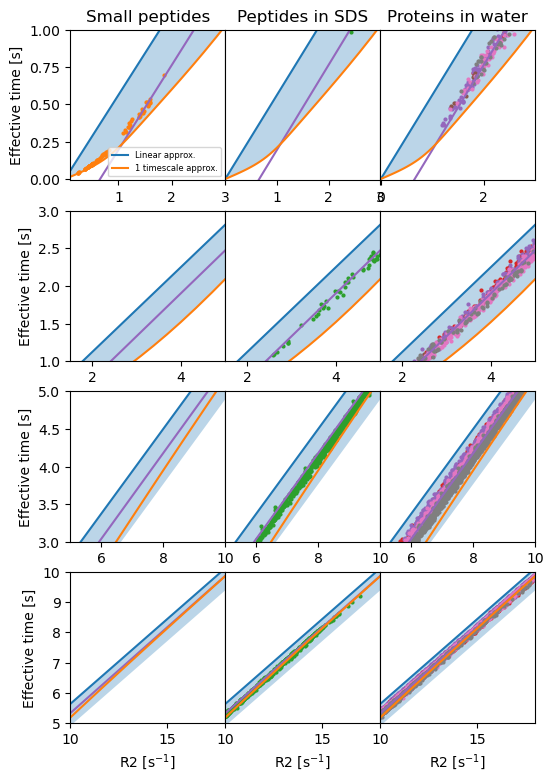

In [56]:
#plotting and analysis limits
eff_time_limits=[1,1,1]

#get fit for all the data
all_x=[]
all_y=[]

for sys in systems:
    all_x+=list(systems[sys][2])
    all_y+=list(systems[sys][0])

fit=np.polyfit(all_x,all_y,1)

# Ensin lasketaan ennustetut arvot suoralle
sorted_x=sorted(all_x)
y_predicted = fit[0] * np.array(all_x) + fit[1]
sorted_y = fit[0] * np.array(sorted_x) + fit[1]



all_x_under=[]
all_y_under=[]
for limit in eff_time_limits:
    all_x_under.append([])
    all_y_under.append([])

    for x,y in zip(sorted_x,sorted_y):
        if y<limit:
            all_x_under[-1].append(x)
            all_y_under[-1].append(y)


ver=4

fig, axs = plt.subplots(ver, 3,  gridspec_kw={'wspace': 0.0, 'hspace': 0.2})

plt.rcParams["figure.figsize"] = [6, 9]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')


axs[0,0].set_xlim(0.1,3)
axs[0,0].set_ylim(-0.01,eff_time_limits[0])

axs[0,1].set_xlim(0.001,3)
axs[0,1].set_ylim(-0.01,eff_time_limits[1])


axs[0,2].set_xlim(-0.01,3)
axs[0,2].set_ylim(-0.01,eff_time_limits[2])

axs[1,0].set_xlim(1.5,5)
axs[1,0].set_ylim(eff_time_limits[0],eff_time_limits[0]*3)

axs[1,1].set_xlim(1.5,5)
axs[1,1].set_ylim(eff_time_limits[1],eff_time_limits[1]*3)


axs[1,2].set_xlim(1.5,5)
axs[1,2].set_ylim(eff_time_limits[2],eff_time_limits[2]*3)


axs[2,0].set_xlim(5,10)
axs[2,0].set_ylim(eff_time_limits[0]*3,eff_time_limits[0]*5)

axs[2,1].set_xlim(5,10)
axs[2,1].set_ylim(eff_time_limits[1]*3,eff_time_limits[1]*5)


axs[2,2].set_xlim(5,10)
axs[2,2].set_ylim(eff_time_limits[2]*3,eff_time_limits[2]*5)


axs[3,0].set_xlim(10,18)
axs[3,0].set_ylim(eff_time_limits[0]*5,eff_time_limits[0]*10)

axs[3,1].set_xlim(10,18)
axs[3,1].set_ylim(eff_time_limits[1]*5,eff_time_limits[1]*10)


axs[3,2].set_xlim(10,18)
axs[3,2].set_ylim(eff_time_limits[2]*5,eff_time_limits[2]*10)

#plt.suptitle(str(magn_field_MHz)+" MHz")

amanda=["Calmodulin",
       "CDNF",
       "EN2",
       "musMANF",
       "TonB"]
    

for vertical in range(ver):
    axs[vertical,0].plot(systems["small_peptides"][2],systems["small_peptides"][0],"o",c="C1", markersize=2)
    axs[vertical,1].plot(systems["peptides_SDSmicelles"][2],systems["peptides_SDSmicelles"][0],"o",c="C2", markersize=2)
       

    for i, system in enumerate(amanda):
        axs[vertical,2].plot(systems[system][2],systems[system][0],"o",c="C"+str(3+i), markersize=2)
   


axs[0,0].set_title("Small peptides")
axs[0,1].set_title("Peptides in SDS")
axs[0,2].set_title("Proteins in water")

wh = gammaH * magnetic_field 
wn = gammaN * magnetic_field 

T1, T2, NOE, x = srt.getSRT(-20,-3,200,magnetic_field)

mu = 4 * np.pi * 10**(-7) #magnetic constant of vacuum permeability
h_planck = 1.055 * 10**(-34); #reduced Planck constant
rN = 0.101 * 10**(-9); # average cubic length of N-H bond
d = 1 * (mu * gammaN * gammaH * h_planck) / (4 * np.pi * rN**3); # dipolar coupling constant

K1=(d**2 / 20)
K2=(wn * 160 * 10**(-6))**2 / 45


eff_from_R2_approx=1/((4*K1+4*K2)*T2)*10**9

for horizantal in range(3):
    for vertical in range(ver):
        axs[vertical,horizantal].plot(1/T2,eff_from_R2_approx,"-",label="Linear approx.")
        axs[vertical,horizantal].plot(sorted_x,sorted_y,c="C4")
        axs[vertical,horizantal].fill(limits["R2"][1], limits["R2"][0]*10**9,  alpha=0.3)
        axs[vertical,horizantal].plot(oneTime["R2"][1],oneTime["R2"][0]*10**9,"-",label="1 timescale approx.")
        axs[ver-1,horizantal].set_xlabel("R2 [s$^{-1}$]")
        axs[vertical,0].set_ylabel("Effective time [s]")
for horizantal in range(1,3):
    for vertical in range(ver):
        axs[vertical,horizantal].set_yticks([])
        

axs[0,0].legend(prop={"size":6})

#plt.title("Possible effective times for T1 measuraments at "+str(magn_field_MHz)+" MHZ")

#plt.savefig("eff_vs_T2_details.pdf")

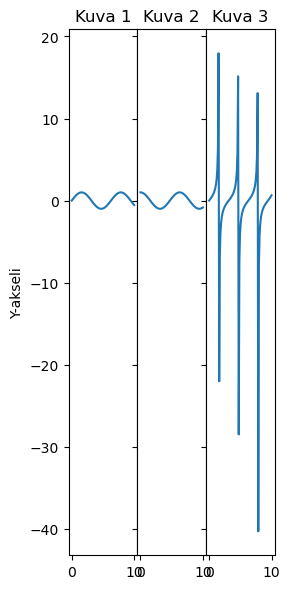

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Luodaan dataa esimerkin vuoksi
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)

# Luodaan alikuvioita (subplots) ja asetetaan ne vierekkäin
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, gridspec_kw={'wspace': 0})

# Asetetaan otsikot kullekin alikuvioille
ax1.set_title('Kuva 1')
ax2.set_title('Kuva 2')
ax3.set_title('Kuva 3')

# Piirretään data kuhunkin alikuvaan
ax1.plot(x, y1)
ax2.plot(x, y2)
ax3.plot(x, y3)

# Yhteinen y-akseli
ax1.set_ylabel('Y-akseli')

# Näytetään kuva
plt.show()

In [16]:
import scipy
help(scipy.stats.pearsonr)

Help on function pearsonr in module scipy.stats._stats_py:

pearsonr(x, y, *, alternative='two-sided')
    Pearson correlation coefficient and p-value for testing non-correlation.
    
    The Pearson correlation coefficient [1]_ measures the linear relationship
    between two datasets. Like other correlation
    coefficients, this one varies between -1 and +1 with 0 implying no
    correlation. Correlations of -1 or +1 imply an exact linear relationship.
    Positive correlations imply that as x increases, so does y. Negative
    correlations imply that as x increases, y decreases.
    
    This function also performs a test of the null hypothesis that the
    distributions underlying the samples are uncorrelated and normally
    distributed. (See Kowalski [3]_
    for a discussion of the effects of non-normality of the input on the
    distribution of the correlation coefficient.)
    The p-value roughly indicates the probability of an uncorrelated system
    producing datasets that

In [17]:
np.polyfit(systems["small_peptides"][2],systems["small_peptides"][0],1)

array([ 0.37702262, -0.09045333])

In [18]:
np.polyfit(systems["peptides_SDSmicelles"][2],systems["peptides_SDSmicelles"][0],1)

array([ 0.57425335, -0.47106278])

In [39]:
amanda_x=[]
amanda_y=[]

for sys in amanda:
    amanda_x+=list(systems[sys][2])
    amanda_y+=list(systems[sys][0])
    
np.polyfit(amanda_x,amanda_y,1)

array([ 0.56938285, -0.36812813])

In [6]:
all_x=[]
all_y=[]

for sys in systems:
    all_x+=list(systems[sys][2])
    all_y+=list(systems[sys][0])
 
fit=np.polyfit(all_x,all_y,1)

In [66]:
all_x=[]
all_y=[]

for sys in systems:
    all_x+=list(systems[sys][2])
    all_y+=list(systems[sys][0])


# Ensin lasketaan ennustetut arvot suoralle
sorted_x=sorted(all_x)
y_predicted = fit[0] * np.array(all_x) + fit[1]
sorted_y = fit[0] * np.array(sorted_x) + fit[1]


# Sitten lasketaan R^2-arvo
residuals = all_y - y_predicted
ss_residuals = np.sum(residuals**2)
ss_total = np.sum((all_y - np.mean(all_y))**2)
r_squared = 1 - (ss_residuals / ss_total)

print("R^2-arvo:", r_squared, "slope:",fit[0],", intersept:",fit[1])

R^2-arvo: 0.9997692809208122 slope: 0.5695872846048775 , intersept: -0.3747227686444632


In [25]:
np.polyfit(list(systems["small_peptides"][2])+list(systems["peptides_SDSmicelles"][2]),list(systems["small_peptides"][0])+list(systems["peptides_SDSmicelles"][0]),1)

array([ 0.56453025, -0.36728412])

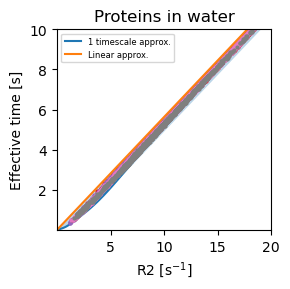

In [42]:
gammaH=267.513*10**6;
gammaN=-27.166*10**6;

fig, axs = plt.subplots(1, 1)

plt.rcParams["figure.figsize"] = [3, 3]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')


x2=np.logspace((-12),(-7),100)
axs.plot(oneTime["R2"][1],oneTime["R2"][0]*10**9,"-",label="1 timescale approx.")


axs.fill(limits["R2"][1], limits["R2"][0]*10**9,  alpha=0.3)


axs.set_xlim(0.1,2.5)
axs.set_ylim(10**(-3),0.00075*10**(3))

axs.set_xlim(0.001,20)
axs.set_ylim(10**(-3),0.010*10**(3))


    
for i, system in enumerate(amanda):
    axs.plot(systems[system][2],systems[system][0],"o",c="C"+str(3+i), markersize=2)
  


axs.set_ylabel("Effective time [s]")
#axs[0].set_xlabel("T2 [s]")

axs.set_xlabel("R2 [s$^{-1}$]")

axs.set_title("Proteins in water")

wh = gammaH * magnetic_field 
wn = gammaN * magnetic_field 

T1, T2, NOE, x = getSRT(-20,-3,200,magnetic_field)

mu = 4 * np.pi * 10**(-7) #magnetic constant of vacuum permeability
h_planck = 1.055 * 10**(-34); #reduced Planck constant
rN = 0.101 * 10**(-9); # average cubic length of N-H bond
d = 1 * (mu * gammaN * gammaH * h_planck) / (4 * np.pi * rN**3); # dipolar coupling constant

K1=(d**2 / 20)
K2=(wn * 160 * 10**(-6))**2 / 45


eff_from_R2_approx=1/((4*K1+4*K2)*T2)*10**9



axs.plot(1/T2,eff_from_R2_approx,label="Linear approx.")

axs.legend(prop={"size":6})
plt.savefig("zoom_less_at_big_proteins_in_water.pdf")
#plt.title("Possible effective times for T1 measuraments at "+str(magn_field_MHz)+" MHZ")

In [50]:
fast_x=[]
fast_y=[]
for i,value in enumerate(amanda_x):
    if value>35:
        fast_x.append(value)
        fast_y.append(amanda_y[i])

In [56]:
fast_y

[24.4776303385251,
 23.23461400706011,
 22.521434591008706,
 25.839825589934875,
 22.017469828112567,
 33.05071587211846,
 25.599925470897283,
 26.426711023504314,
 31.734866612055356,
 21.561537681601266,
 25.905054866457164,
 25.445850284062747,
 25.2400509198703,
 32.38699212048871,
 21.952571964179928,
 28.88321179331537,
 20.228304875862836,
 20.178069838300516,
 25.120586550989906,
 20.255384095404697,
 27.83585389981926,
 23.226259010773127,
 29.950175301759934,
 20.72848725484712,
 22.96984475033929,
 26.70237094241301,
 26.148452848609352,
 21.455209143516097,
 23.50521038413445,
 22.075041330673802,
 25.337615880188018,
 21.430961758535037,
 21.50242017345661,
 22.772144205482682,
 20.367671830791945,
 32.649247754359415,
 33.36789755040056,
 29.484844522899415,
 32.34833840679315,
 19.964650795044992,
 24.2591310691338,
 25.22103165189508,
 25.051884970389835,
 33.460703039890305,
 30.3048002256282,
 22.141203535987717,
 20.63995472389187,
 19.691359769242318,
 28.4068128514

In [51]:
np.polyfit(fast_x,fast_y,1)

array([ 0.56282802, -0.19261114])

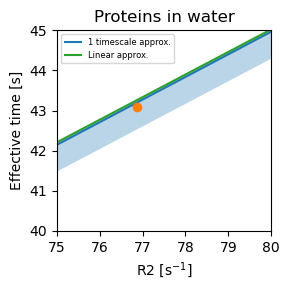

In [62]:
fig, axs = plt.subplots(1, 1)

plt.rcParams["figure.figsize"] = [3, 3]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')


x2=np.logspace((-12),(-7),100)
axs.plot(oneTime["R2"][1],oneTime["R2"][0]*10**9,"-",label="1 timescale approx.")


axs.fill(limits["R2"][1], limits["R2"][0]*10**9,  alpha=0.3)


axs.set_xlim(0.1,2.5)
axs.set_ylim(10**(-3),0.00075*10**(3))

axs.set_xlim(75,80)
axs.set_ylim(0.040*10**(3),0.045*10**(3))


    
#for i, system in enumerate(amanda):
#    axs.plot(systems[system][2],systems[system][0],"o",c="C"+str(3+i), markersize=2)
 
axs.plot(fast_x,fast_y,"o")


axs.set_ylabel("Effective time [s]")
#axs[0].set_xlabel("T2 [s]")

axs.set_xlabel("R2 [s$^{-1}$]")

axs.set_title("Proteins in water")

wh = gammaH * magnetic_field 
wn = gammaN * magnetic_field 

T1, T2, NOE, x = srt.getSRT(-20,-3,200,magnetic_field)

mu = 4 * np.pi * 10**(-7) #magnetic constant of vacuum permeability
h_planck = 1.055 * 10**(-34); #reduced Planck constant
rN = 0.101 * 10**(-9); # average cubic length of N-H bond
d = 1 * (mu * gammaN * gammaH * h_planck) / (4 * np.pi * rN**3); # dipolar coupling constant

K1=(d**2 / 20)
K2=(wn * 160 * 10**(-6))**2 / 45


eff_from_R2_approx=1/((4*K1+4*K2)*T2)*10**9



axs.plot(1/T2,eff_from_R2_approx,label="Linear approx.")

axs.legend(prop={"size":6})
